In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA


## Just to get dataframe

In [182]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_23_2023_LSTN_subject2\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2f', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(sub.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")

     bodyparts StablePoint StablePoint.1 StablePoint.2   PalmBase PalmBase.1  \
0       coords           x             y    likelihood          x          y   
1            0   312.37256     90.169426     0.9454463  267.89175  287.26443   
2            1    312.2302      90.40724     0.9373964  265.75037  284.86755   
3            2   312.24457      90.30127    0.93601197  265.21674   284.9264   
4            3   311.87827      90.29879     0.9441474  265.31732   286.3712   
...        ...         ...           ...           ...        ...        ...   
1327      1326   312.79306      90.74159     0.9609104   294.0356  367.53326   
1328      1327    312.6162      91.11673    0.96110815  293.51898   368.3171   
1329      1328   312.80075      90.77604     0.9515535   293.1958  368.65656   
1330      1329   312.35977      90.99973     0.9514125  293.29675   368.7996   
1331      1330   312.43835     90.826546     0.9502585  293.31845  368.52686   

      PalmBase.2       MCP1     MCP1.1 

In [183]:
dataframes

{'b1f':       StablePoint  StablePoint.1  StablePoint.2   PalmBase  PalmBase.1  \
 1       312.37256       90.16943        0.94545  267.89175   287.26443   
 2       312.23020       90.40724        0.93740  265.75037   284.86755   
 3       312.24457       90.30127        0.93601  265.21674   284.92640   
 4       311.87827       90.29879        0.94415  265.31732   286.37120   
 5       312.10486       90.22673        0.94731  264.61510   286.81845   
 ...           ...            ...            ...        ...         ...   
 1327    312.79306       90.74159        0.96091  294.03560   367.53326   
 1328    312.61620       91.11673        0.96111  293.51898   368.31710   
 1329    312.80075       90.77604        0.95155  293.19580   368.65656   
 1330    312.35977       90.99973        0.95141  293.29675   368.79960   
 1331    312.43835       90.82655        0.95026  293.31845   368.52686   
 
       PalmBase.2       MCP1     MCP1.1   MCP1.2       MCP2  ...  fTip4.2  \
 1            

## Run PCA for each depth and compare front and side

In [159]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)


In [ ]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    mov = 'all'  # looking at full video, not yet sectioning out the movements
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)


    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 component weights (loadings)
    pc1 = components[0]

    # Create a dict for this depth/view row
    row = {
        "depth": depth,
        "view": view_type,
    }

    # Add feature component weights to the dict
    for feat, weight in zip(final_cols, pc1):
        row[feat] = weight

    # Append to pca1_rows list
    pca1_rows.append(row)

    pca1_df = pd.DataFrame(pca1_rows)



    # help print out PC1 values
    # Save PCA scores per timepoint 
    for j in range(X_pca.shape[0]):
        row_dict = {
            "dataset": base,
            "movement": mov,
            "view": view_type,
        }

        # for each timepoint within the data, it is saving the PC for each time point (so each frame) 
        for pc_index in range(X_pca.shape[1]):
            row_dict[f"PC{pc_index + 1}"] = X_pca[j, pc_index]

        # separating front and side PCs (can be used later for visualization)
        if view_type == "front":
            rows_front.append(row_dict)
        else:
            rows_side.append(row_dict)

        
    # Get weights of PC1
    pc1 = components[0]  # PC1 = first row of the PCA component matrix

    # Match each weight to its feature name
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Show top 5 contributing features
    top5 = feature_contributions[:5]
    for feat, weight in top5:
        print(f"For {base} {feat}: {weight:.4f}")



 For b1f the variance for PC1 is 0.4677905808992578 and PC2 is 0.32938786613912907
For b1f fTip3: 0.2404
For b1f Elbow.1: 0.2390
For b1f fTip4: 0.2353
For b1f fTip2: 0.2338
For b1f fTip5: 0.2245
 For b1s the variance for PC1 is 0.5357547137482518 and PC2 is 0.34507681255901573
For b1s MCP3: 0.2495
For b1s MCP2: 0.2492
For b1s MCP4: 0.2487
For b1s MCP5: 0.2477
For b1s PalmBase: 0.2452
 For b2f the variance for PC1 is 0.5425782753439766 and PC2 is 0.19466294977005266
For b2f MCP2.1: 0.2398
For b2f fTip2.1: 0.2362
For b2f MCP3.1: 0.2321
For b2f fTip1.1: 0.2292
For b2f MidForeArm.1: 0.2261
 For b2s the variance for PC1 is 0.45664887201924204 and PC2 is 0.4207500179125021
For b2s MCP5: 0.2646
For b2s MCP4: 0.2646
For b2s MCP3: 0.2635
For b2s MCP2: 0.2611
For b2s fTip5: 0.2581
 For b3f the variance for PC1 is 0.4582204508156575 and PC2 is 0.28808398153610515
For b3f MCP2.1: 0.2457
For b3f fTip2.1: 0.2404
For b3f fTip1.1: 0.2382
For b3f fTip3: 0.2362
For b3f MCP1.1: 0.2334
 For b3s the varian

In [185]:
pca1_df

,depth,view,StablePoint,StablePoint.1,PalmBase,PalmBase.1,MCP1,MCP1.1,MCP2,MCP2.1,...,fTip3,fTip3.1,fTip4,fTip4.1,fTip5,fTip5.1,MidForeArm,MidForeArm.1,Elbow,Elbow.1
0,b1,front,0.072512,0.098063,0.193327,0.144827,0.217645,0.195934,0.177392,0.207270,...,0.240434,0.190490,0.235319,0.165304,0.224488,0.136098,0.134480,0.180939,-0.204687,0.239025
1,b1,side,0.150637,0.213881,0.245167,0.094598,0.244229,0.086103,0.249181,0.038656,...,0.244038,0.148308,0.243368,0.173748,0.236670,0.174144,0.243628,0.053236,-0.136658,-0.084809
2,b2,front,0.009285,0.081313,0.166339,0.207086,-0.148676,-0.124570,0.173614,0.239753,...,-0.127118,-0.121960,0.221301,0.223118,0.207352,0.210992,0.072197,0.226123,-0.149018,0.222607
3,b2,side,0.116816,0.227356,0.256943,0.102888,0.250384,0.076826,0.261108,0.043886,...,0.051333,-0.105291,0.254893,0.155233,0.258142,0.174002,0.253385,0.069836,-0.131712,-0.152449
4,b3,front,0.023556,0.089447,0.175963,0.187068,0.181697,0.233373,0.142140,0.245700,...,0.236202,0.223609,0.229431,0.203174,0.214979,0.171958,0.085893,0.215248,0.018022,0.086773
5,b3,side,0.168452,0.246810,0.271617,0.013971,0.269444,-0.010672,0.272870,-0.049318,...,0.272103,0.051741,0.235585,0.075435,0.270569,0.116149,0.270334,-0.020877,-0.023878,-0.068105
6,c1,front,0.026030,0.008659,-0.247674,0.274866,-0.205628,0.204478,-0.176685,0.224786,...,-0.201415,0.208032,-0.190216,0.212919,-0.196555,0.221815,0.022015,0.022015,NaN,NaN
7,c1,side,0.146705,0.097187,0.230091,0.163830,0.243886,0.137766,0.239341,0.089909,...,0.228286,0.166280,0.221211,0.176207,0.214054,0.196789,0.224205,0.139525,-0.176163,0.020269
8,c2,front,-0.033486,0.004540,0.147439,0.210825,0.166345,0.236851,0.154289,0.231860,...,0.180409,0.225958,0.190785,0.229896,0.185334,0.223845,-0.213577,-0.205539,-0.207372,-0.180893
9,c2,side,-0.036403,0.112832,0.204562,0.213909,0.191881,0.194121,0.211422,0.183549,...,0.200195,0.207638,0.200381,0.216225,0.205837,0.226067,0.212691,0.196477,-0.109559,0.123258


In [187]:
# List of feature columns (excluding non-feature cols)
exclude_cols = ['depth', 'view', 'movement']
feature_cols = [col for col in pca1_df.columns if col not in exclude_cols]

for i in range(len(pca1_df) - 1):
    row1 = pca1_df.iloc[i]
    row2 = pca1_df.iloc[i + 1]

    if row1['depth'] == row2['depth']:
        print(f"Top 5 components for depth '{row1['depth']}' row {i}:")
        top5_row1 = row1[feature_cols].abs().sort_values(ascending=False).head(5)
        print("Row 1 top 5 features:")
        print(top5_row1)

        print(f"Top 5 components for depth '{row2['depth']}' row {i+1}:")
        top5_row2 = row2[feature_cols].abs().sort_values(ascending=False).head(5)
        print("Row 2 top 5 features:")
        print(top5_row2)

        # Calculate average of the two rows' feature values
        avg_features = (row1[feature_cols] + row2[feature_cols]) / 2

        # Get top 5 highest average values
        top5_avg = avg_features.sort_values(ascending=False).head(5)
        print("Top 5 features by average value between the two rows:")
        print(top5_avg)

        print("\n" + "-"*40 + "\n")


Top 5 components for depth 'b1' row 0:
Row 1 top 5 features:
fTip3      0.240434
Elbow.1    0.239025
fTip4      0.235319
fTip2      0.233802
fTip5      0.224488
Name: 0, dtype: object
Top 5 components for depth 'b1' row 1:
Row 2 top 5 features:
MCP3        0.249545
MCP2        0.249181
MCP4        0.248655
MCP5         0.24772
PalmBase    0.245167
Name: 1, dtype: object
Top 5 features by average value between the two rows:
fTip3    0.242236
fTip4    0.239344
fTip2    0.239209
MCP5     0.235591
MCP4     0.231873
dtype: object

----------------------------------------

Top 5 components for depth 'b2' row 2:
Row 1 top 5 features:
MCP2.1          0.239753
fTip2.1         0.236234
MCP3.1           0.23207
fTip1.1         0.229204
MidForeArm.1    0.226123
Name: 2, dtype: object
Top 5 components for depth 'b2' row 3:
Row 2 top 5 features:
MCP5     0.264611
MCP4      0.26456
MCP3     0.263513
MCP2     0.261108
fTip5    0.258142
Name: 3, dtype: object
Top 5 features by average value between the

In [188]:
# Store the top contributor per (depth, view)
top_contributors = {}

# Loop through unique combinations of depth and view
for (depth_val, view_val), group in pca1_df.groupby(['depth', 'view']):
    # Average across rows for this group (in case there are multiple)
    feature_cols = [col for col in pca1_df.columns if col not in ['depth', 'view', 'movement']]
    avg_features = group[feature_cols].mean()

    # Find the top contributing feature (by absolute value)
    top_feature = avg_features.abs().idxmax()
    top_value = avg_features[top_feature]

    # Store in dictionary
    top_contributors[(depth_val, view_val)] = {
        'feature': top_feature,
        'value': top_value
    }


top_contributors

{('b1', 'front'): {'feature': 'fTip3',
  'value': np.float64(0.24043419281358264)},
 ('b1', 'side'): {'feature': 'MCP3', 'value': np.float64(0.24954492817751808)},
 ('b2', 'front'): {'feature': 'MCP2.1',
  'value': np.float64(0.23975290608577007)},
 ('b2', 'side'): {'feature': 'MCP5', 'value': np.float64(0.2646106026113346)},
 ('b3', 'front'): {'feature': 'MCP2.1',
  'value': np.float64(0.24570031801175202)},
 ('b3', 'side'): {'feature': 'MCP3', 'value': np.float64(0.27345434265144086)},
 ('c1', 'front'): {'feature': 'PalmBase.1',
  'value': np.float64(0.2748659321536181)},
 ('c1', 'side'): {'feature': 'MCP1', 'value': np.float64(0.2438863142310708)},
 ('c2', 'front'): {'feature': 'MCP1.1',
  'value': np.float64(0.23685143031387285)},
 ('c2', 'side'): {'feature': 'MCP5.1',
  'value': np.float64(0.22698937217113574)},
 ('c3', 'front'): {'feature': 'MCP1.1',
  'value': np.float64(0.2417963780279968)},
 ('c3', 'side'): {'feature': 'fTip5.1',
  'value': np.float64(0.2268708934921225)},
 ('

<Figure size 1000x300 with 0 Axes>

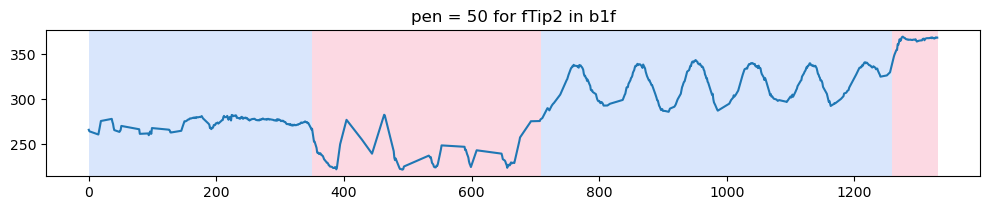

<Figure size 1000x300 with 0 Axes>

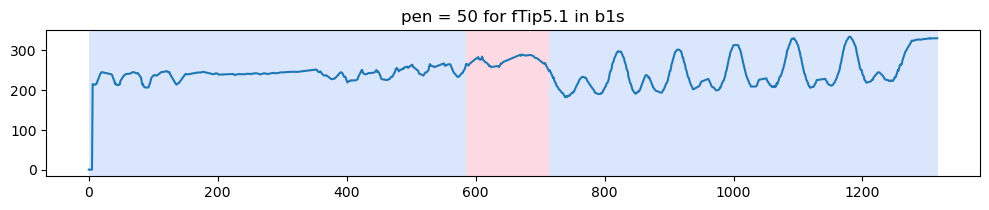

<Figure size 1000x300 with 0 Axes>

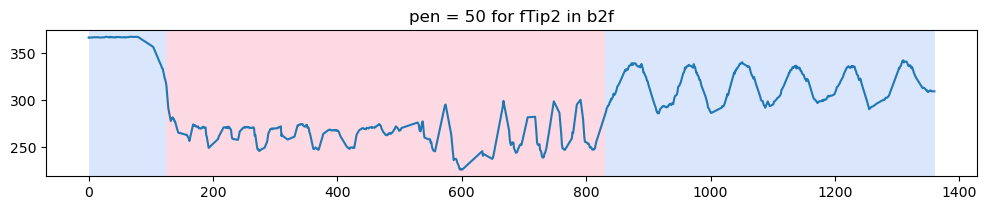

<Figure size 1000x300 with 0 Axes>

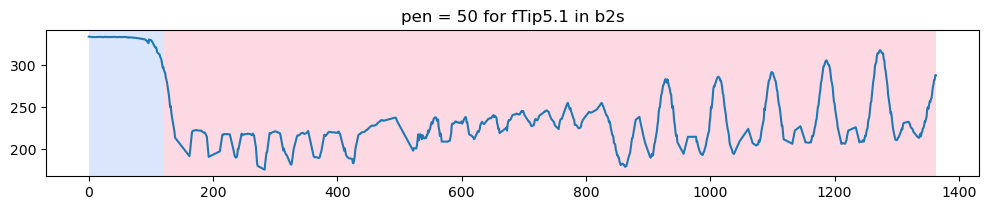

<Figure size 1000x300 with 0 Axes>

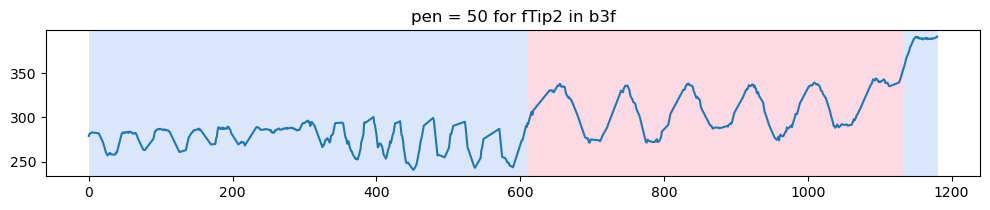

<Figure size 1000x300 with 0 Axes>

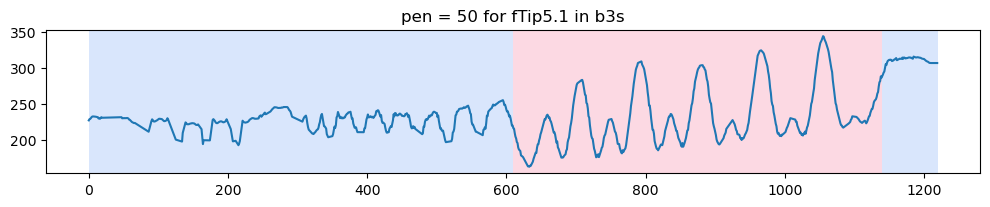

<Figure size 1000x300 with 0 Axes>

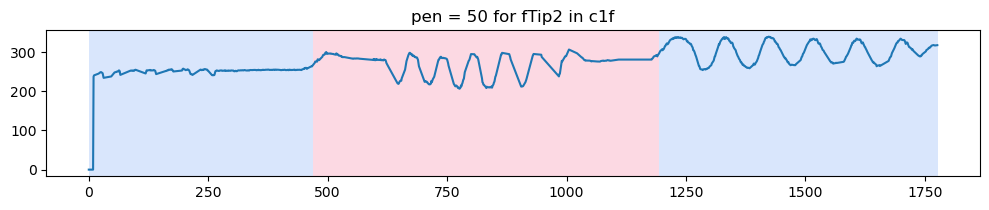

<Figure size 1000x300 with 0 Axes>

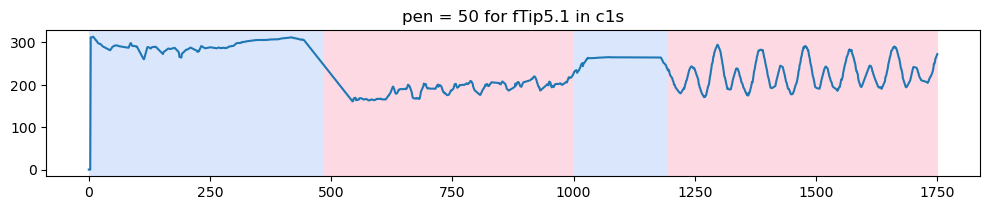

<Figure size 1000x300 with 0 Axes>

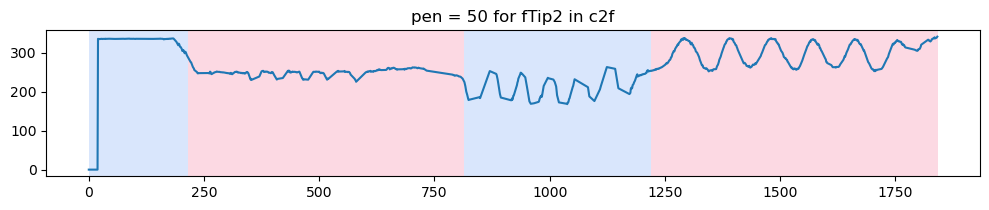

<Figure size 1000x300 with 0 Axes>

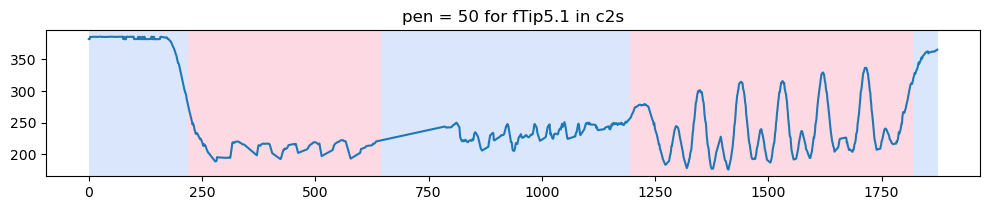

<Figure size 1000x300 with 0 Axes>

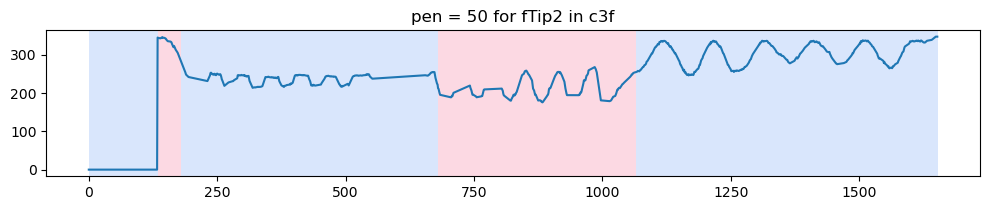

<Figure size 1000x300 with 0 Axes>

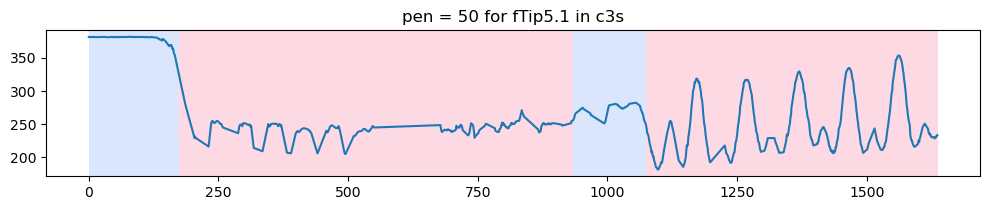

<Figure size 1000x300 with 0 Axes>

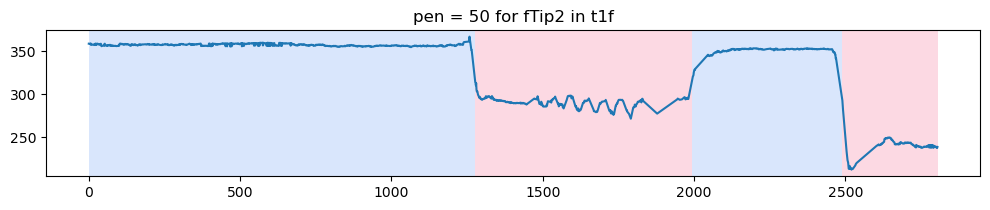

<Figure size 1000x300 with 0 Axes>

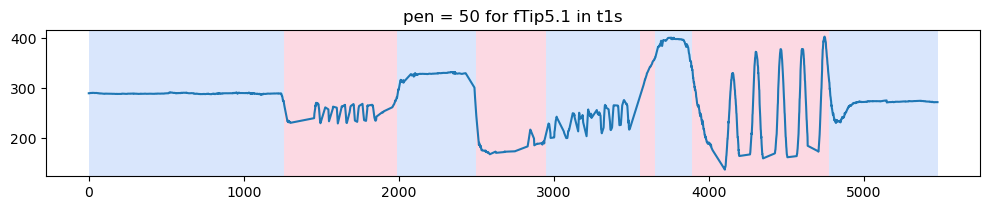

<Figure size 1000x300 with 0 Axes>

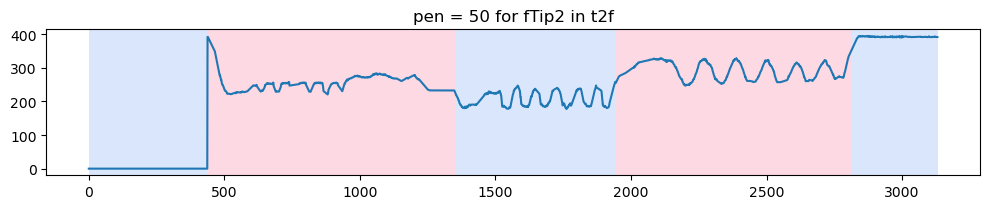

<Figure size 1000x300 with 0 Axes>

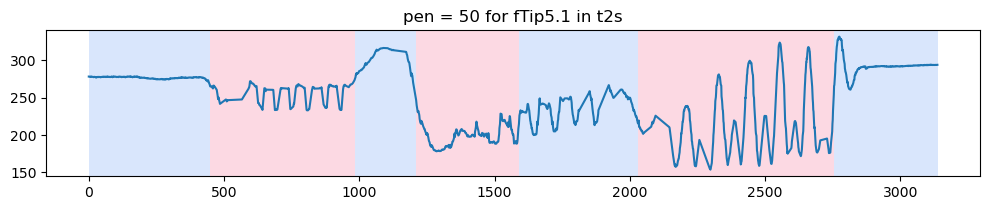

<Figure size 1000x300 with 0 Axes>

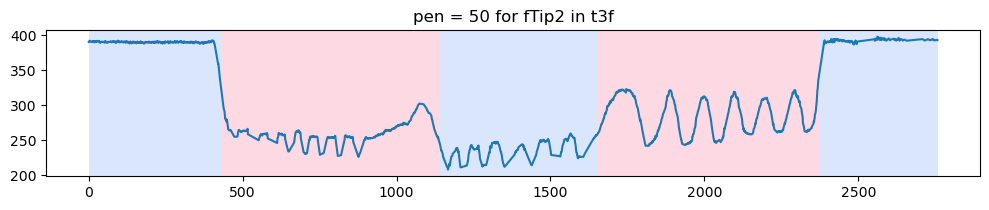

<Figure size 1000x300 with 0 Axes>

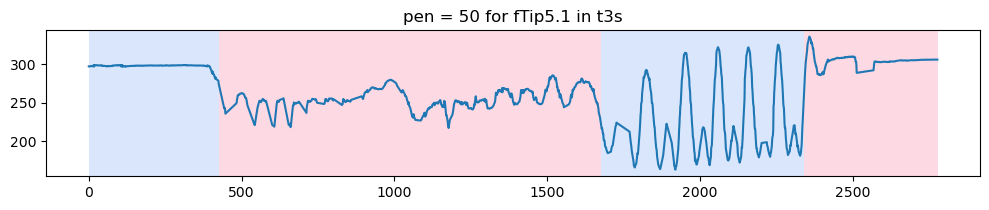

  dataset        front         side  front_length
0      b1  [475, 1777]  [475, 1777]             2
1      b2  [475, 1777]  [475, 1777]             2
2      b3  [475, 1777]  [475, 1777]             2
3      c1  [475, 1777]  [475, 1777]             2
4      c2  [475, 1777]  [475, 1777]             2
5      c3  [475, 1777]  [475, 1777]             2
6      t1  [475, 1777]  [475, 1777]             2
7      t2  [475, 1777]  [475, 1777]             2
8      t3  [475, 1777]  [475, 1777]             2


In [195]:
# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    # Get the top feature for this depth and view
    top_feature = top_contributors.get((depth, view), {}).get('feature')

    points = data[top_feature]
    points_np = points.to_numpy()

    algo = rpt.Pelt(model='rbf').fit(points_np)
    cps = algo.predict(pen=50)

    plt.figure(figsize=(10, 3))
    rpt.display(points_np, cps)
    plt.title(f'pen = {50} for {top_feature} in {df_name}')
    plt.show()

    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = change_points

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)

df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

print(df_indices)




In [ ]:
success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [4, 5]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df[top_feature].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label=top_feature)
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel(top_feature)
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title here
fig.suptitle("Change for sub2_LSTN  determined by PCA", fontsize=16)

# Adjust layout to make room for suptitle
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['PalmBase'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Separate df_indices rows by view type
front_rows = df_indices[df_indices['view'] == 'front']
side_rows = df_indices[df_indices['view'] == 'side']

def plot_view_group(rows, view_label):
    n = len(rows)
    fig, axes = plt.subplots(nrows=n, figsize=(8, 3 * n), sharex=False)
    if n == 1:
        axes = [axes]  # ensure it's always iterable

    for i, (_, row) in enumerate(rows.iterrows()):
        base_name = row['dataset']
        view = row['view']
        name = base_name + ('f' if view == 'front' else 's')

        # Fetch top feature for this depth+view
        top_feature = top_contributors.get((base_name, view), {}).get('feature', None)
        if not top_feature or name not in dataframes:
            continue  # skip if data is missing

        df = dataframes[name]
        signal = df[top_feature].to_numpy()
        time = np.arange(len(signal))
        change_points = row[view]  # column 'front' or 'side' has changepoints

        # Plot
        ax = axes[i]
        ax.plot(time, signal, label=top_feature)
        for cp in change_points:
            ax.axvline(cp, color='red', linestyle='--')

        ax.set_title(f"{name} - {view} - {top_feature}")
        ax.set_xlabel("Frame")
        ax.set_ylabel(top_feature)
        ax.grid(True)

    fig.suptitle(f"Top Feature per Depth - {view_label} View", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Call for both views
plot_view_group(front_rows, "Front")
plot_view_group(side_rows, "Side")


KeyError: 'view'

## Run PCA for whole movement

In [136]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
IO_03_09_2023_RSTN = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_04_05_2023_RSTN_subject2\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(IO_03_09_2023_RSTN.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(IO_03_09_2023_RSTN.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")

     bodyparts            PalmBase          PalmBase.1          PalmBase.2  \
0       coords                   x                   y          likelihood   
1            0   348.5385437011719   310.5820007324219  0.9984731078147888   
2            1  348.65338134765625   309.1881103515625  0.9991598129272461   
3            2  348.61846923828125   308.6223449707031  0.9993149042129517   
4            3  348.90985107421875  307.25787353515625  0.9994304776191711   
...        ...                 ...                 ...                 ...   
1743      1742   351.8250427246094   321.5764465332031  0.9982612729072571   
1744      1743   351.3022766113281   321.2947998046875  0.9984922409057617   
1745      1744   352.2962341308594    321.633544921875  0.9984844326972961   
1746      1745  352.17303466796875   321.7185974121094   0.998428463935852   
1747      1746    351.973876953125   321.7456970214844  0.9981639981269836   

                    MCP1              MCP1.1                MCP

In [137]:
def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)


In [138]:
rows_front = []
rows_side = []

for i, (idx, row) in enumerate(df_movements.iterrows()):
    base = row['dataset']     # like 'b1', 't2'
    mov = row['movement']     # e.g., 'press', 'extend'

    f = dataframes.get(base + 'f')
    s = dataframes.get(base + 's')

    both_view = [(base + "f", f, "front"), (base + "s", s, "side")]

    for label, view, view_type in both_view:
        if view is None:
            print(f"Warning: Missing data for {label}. Skipping.")
            continue

        # 🧹 Trim zeros from beginning of view
        view_trimmed = trim_initial_zeros(view)

        # 🚀 Run PCA on trimmed data
        X_pca, explained_variance, components = run_PCA(view_trimmed, None, label, mov)

        for j in range(X_pca.shape[0]):
            row_dict = {
                "dataset": base,
                "movement": mov,
                "view": view_type,
            }
            for pc_index in range(X_pca.shape[1]):
                row_dict[f"PC{pc_index + 1}"] = X_pca[j, pc_index]

            if view_type == "front":
                rows_front.append(row_dict)
            else:
                rows_side.append(row_dict)


In [139]:
pca1_rows = []

for i, (idx, row) in enumerate(df_movements.iterrows()):
    base = row['dataset']     # like 'b1', 't2'
    mov = row['movement']     # e.g., 'press', 'extend'

    f = dataframes.get(base + 'f')
    s = dataframes.get(base + 's')

    both_view = [(base + "f", f, "front"), (base + "s", s, "side")]

    for label, view, view_type in both_view:
        if view is None:
            print(f"Warning: Missing data for {label}. Skipping.")
            continue

        # 🧹 Trim zeros from beginning of view
        view_trimmed = trim_initial_zeros(view)

        # 🚀 Run PCA on trimmed data
        X_pca, explained_variance, components = run_PCA(view_trimmed, None, label, mov)

        # Get original columns used in PCA (excluding dropped/constant ones)
        used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
        stds = used_columns.std(axis=0)
        final_cols = used_columns.loc[:, stds != 0].columns.tolist()

        # Save PC1 loadings
        pc1 = components[0]
        row_dict = {"depth": base, "view": view_type, "movement": mov}
        for feat, score in zip(final_cols, pc1):
            row_dict[feat] = score

        pca1_rows.append(row_dict)


In [140]:
PCA1_scores = pd.DataFrame(pca1_rows)
PCA1_scores


,depth,view,movement,PalmBase,PalmBase.1,MCP1,MCP1.1,MCP2,MCP2.1,MCP3,...,fTip1,fTip1.1,fTip2,fTip2.1,fTip3,fTip3.1,fTip4,fTip4.1,fTip5,fTip5.1
0,t2,front,hand_OC,0.257416,0.241492,0.264004,0.243851,0.196323,-0.024888,0.193139,...,0.209367,-0.076951,0.268477,0.256621,0.268337,0.257291,0.268010,0.258368,0.266617,0.259288
1,t2,side,hand_OC,0.247392,0.270355,0.255234,0.238000,0.203901,0.210838,0.183126,...,0.242373,0.227973,0.174761,0.151041,0.169026,0.148272,0.164312,0.164907,0.170891,0.205259
2,t2,front,arm_EF,0.257416,0.241492,0.264004,0.243851,0.196323,-0.024888,0.193139,...,0.209367,-0.076951,0.268477,0.256621,0.268337,0.257291,0.268010,0.258368,0.266617,0.259288
3,t2,side,arm_EF,0.247392,0.270355,0.255234,0.238000,0.203901,0.210838,0.183126,...,0.242373,0.227973,0.174761,0.151041,0.169026,0.148272,0.164312,0.164907,0.170891,0.205259


In [141]:
# Select only numeric columns to average
numeric_cols = PCA1_scores.select_dtypes(include='number').columns

# Calculate the mean of those numeric columns
avg_row = PCA1_scores[numeric_cols].mean()

# Add the 'depth' label (and optionally 'view' and 'movement' if you want)
avg_row['depth'] = 'avg'
# If you want, add dummy labels or leave them blank
avg_row['view'] = ''
avg_row['movement'] = ''

# Append the average row to the DataFrame
PCA1_scores_with_avg = pd.concat([PCA1_scores, avg_row.to_frame().T], ignore_index=True)


In [142]:
# Display the average row
avg_row = PCA1_scores_with_avg[PCA1_scores_with_avg['depth'] == 'avg']
print(avg_row)


  depth view movement  PalmBase PalmBase.1      MCP1    MCP1.1      MCP2  \
4   avg                0.252404   0.255924  0.259619  0.240926  0.200112   

     MCP2.1      MCP3  ...    fTip1   fTip1.1     fTip2   fTip2.1     fTip3  \
4  0.092975  0.188133  ...  0.22587  0.075511  0.221619  0.203831  0.218682   

    fTip3.1     fTip4   fTip4.1     fTip5   fTip5.1  
4  0.202782  0.216161  0.211638  0.218754  0.232274  

[1 rows x 25 columns]


In [143]:
# Select the avg row as a Series
avg_row = PCA1_scores_with_avg[PCA1_scores_with_avg['depth'] == 'avg'].iloc[0]

# Drop non-numeric columns manually
exclude_cols = ['depth', 'view', 'movement']
numeric_data = avg_row.drop(labels=exclude_cols, errors='ignore')

# Now get top 5 features by highest average PCA1 score
top5 = numeric_data.sort_values(ascending=False).head(5)

print("Top 5 features by average PCA1 score:")
print(top5)


Top 5 features by average PCA1 score:
MCP1          0.259619
PalmBase.1    0.255924
PalmBase      0.252404
MCP1.1        0.240926
fTip5.1       0.232274
Name: 4, dtype: object


In [144]:
# First, group by 'view' and calculate the mean for all numeric PCA1 columns
# Exclude non-numeric columns from averaging
exclude_cols = ['depth', 'view', 'movement']

# Select only numeric columns for averaging
numeric_cols = [col for col in PCA1_scores_with_avg.columns if col not in exclude_cols]

# Group by 'view' and calculate mean of numeric columns
avg_by_view = PCA1_scores_with_avg.groupby('view')[numeric_cols].mean()

# Now find top 5 features for each view
for view_name, row in avg_by_view.iterrows():
    top5 = row.sort_values(ascending=False).head(5)
    print(f"Top 5 features by average PCA1 score for {view_name} view:")
    print(top5)
    print()


Top 5 features by average PCA1 score for  view:
MCP1          0.259619
PalmBase.1    0.255924
PalmBase      0.252404
MCP1.1        0.240926
fTip5.1       0.232274
Name: , dtype: object

Top 5 features by average PCA1 score for front view:
fTip2    0.268477
fTip3    0.268337
fTip4     0.26801
fTip5    0.266617
MCP1     0.264004
Name: front, dtype: object

Top 5 features by average PCA1 score for side view:
MCP5.1        0.270529
PalmBase.1    0.270355
MCP5          0.256384
MCP1          0.255234
PalmBase      0.247392
Name: side, dtype: object



## Code for Full PCA - Reports back top 5

In [147]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_04_05_2023_RSTN_subject2\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(sub.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")

dataframes

     bodyparts            PalmBase          PalmBase.1          PalmBase.2  \
0       coords                   x                   y          likelihood   
1            0   348.5385437011719   310.5820007324219  0.9984731078147888   
2            1  348.65338134765625   309.1881103515625  0.9991598129272461   
3            2  348.61846923828125   308.6223449707031  0.9993149042129517   
4            3  348.90985107421875  307.25787353515625  0.9994304776191711   
...        ...                 ...                 ...                 ...   
1743      1742   351.8250427246094   321.5764465332031  0.9982612729072571   
1744      1743   351.3022766113281   321.2947998046875  0.9984922409057617   
1745      1744   352.2962341308594    321.633544921875  0.9984844326972961   
1746      1745  352.17303466796875   321.7185974121094   0.998428463935852   
1747      1746    351.973876953125   321.7456970214844  0.9981639981269836   

                    MCP1              MCP1.1                MCP

{'b1f':        PalmBase  PalmBase.1  PalmBase.2       MCP1     MCP1.1   MCP1.2  \
 1     348.53854   310.58200     0.99847  327.16763  296.67184  0.99638   
 2     348.65338   309.18811     0.99916  327.46259  295.92188  0.99717   
 3     348.61847   308.62234     0.99931  327.40079  294.95123  0.99836   
 4     348.90985   307.25787     0.99943  327.58102  294.03851  0.99831   
 5     349.02374   307.06760     0.99932  327.69598  292.97806  0.99814   
 ...         ...         ...         ...        ...        ...      ...   
 1743  351.82504   321.57645     0.99826  329.13690  310.48996  0.03361   
 1744  351.30228   321.29480     0.99849  329.13690  310.48996  0.02929   
 1745  352.29623   321.63354     0.99848  329.13690  310.48996  0.03006   
 1746  352.17303   321.71860     0.99843  329.13690  310.48996  0.03057   
 1747  351.97388   321.74570     0.99816  329.13690  310.48996  0.02949   
 
            MCP2     MCP2.1   MCP2.2       MCP3  ...  fTip4.2      fTip5  \
 1     336.1038

In [148]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance = pca.explained_variance_ratio_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1

    return X_pca, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)


# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []

for i in dataframes:
    base = i    # like 'b1', 't2'
    mov = 'all'
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance, components = run_PCA(view_trimmed, None, base, mov)


    # Save PCA scores per timepoint
    for j in range(X_pca.shape[0]):
        row_dict = {
            "dataset": base,
            "movement": mov,
            "view": view_type,
        }
        for pc_index in range(X_pca.shape[1]):
            row_dict[f"PC{pc_index + 1}"] = X_pca[j, pc_index]

        if view_type == "front":
            rows_front.append(row_dict)
        else:
            rows_side.append(row_dict)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Save PC1 loadings (feature contributions) for this dataset/view/movement
    pc1 = components[0]
    pca1_dict = {"depth": base, "view": view_type, "movement": mov}
    for feat, score in zip(final_cols, pc1):
        pca1_dict[feat] = score

    pca1_rows.append(pca1_dict)


# Select only numeric columns to average
numeric_cols = PCA1_scores.select_dtypes(include='number').columns

# Calculate the mean of those numeric columns
avg_row = PCA1_scores[numeric_cols].mean()

# Add the 'depth' label (and optionally 'view' and 'movement' if you want)
avg_row['depth'] = 'avg'
# If you want, add dummy labels or leave them blank
avg_row['view'] = ''
avg_row['movement'] = ''

# Append the average row to the DataFrame
PCA1_scores_with_avg = pd.concat([PCA1_scores, avg_row.to_frame().T], ignore_index=True)






# First, group by 'view' and calculate the mean for all numeric PCA1 columns
# Exclude non-numeric columns from averaging
exclude_cols = ['depth', 'view', 'movement']

# Select only numeric columns for averaging
numeric_cols = [col for col in PCA1_scores_with_avg.columns if col not in exclude_cols]

# Group by 'view' and calculate mean of numeric columns
avg_by_view = PCA1_scores_with_avg.groupby('view')[numeric_cols].mean()

# Now find top 5 features for each view
for view_name, row in avg_by_view.iterrows():
    top5 = row.sort_values(ascending=False).head(5)
    print(f"Top 5 features by average PCA1 score for {view_name} view:")
    print(top5)
    print()


Top 5 features by average PCA1 score for  view:
MCP1          0.259619
PalmBase.1    0.255924
PalmBase      0.252404
MCP1.1        0.240926
fTip5.1       0.232274
Name: , dtype: object

Top 5 features by average PCA1 score for front view:
fTip2    0.268477
fTip3    0.268337
fTip4     0.26801
fTip5    0.266617
MCP1     0.264004
Name: front, dtype: object

Top 5 features by average PCA1 score for side view:
MCP5.1        0.270529
PalmBase.1    0.270355
MCP5          0.256384
MCP1          0.255234
PalmBase      0.247392
Name: side, dtype: object



## To Run After to Check

     bodyparts            PalmBase          PalmBase.1          PalmBase.2  \
0       coords                   x                   y          likelihood   
1            0   348.5385437011719   310.5820007324219  0.9984731078147888   
2            1  348.65338134765625   309.1881103515625  0.9991598129272461   
3            2  348.61846923828125   308.6223449707031  0.9993149042129517   
4            3  348.90985107421875  307.25787353515625  0.9994304776191711   
...        ...                 ...                 ...                 ...   
1743      1742   351.8250427246094   321.5764465332031  0.9982612729072571   
1744      1743   351.3022766113281   321.2947998046875  0.9984922409057617   
1745      1744   352.2962341308594    321.633544921875  0.9984844326972961   
1746      1745  352.17303466796875   321.7185974121094   0.998428463935852   
1747      1746    351.973876953125   321.7456970214844  0.9981639981269836   

                    MCP1              MCP1.1                MCP

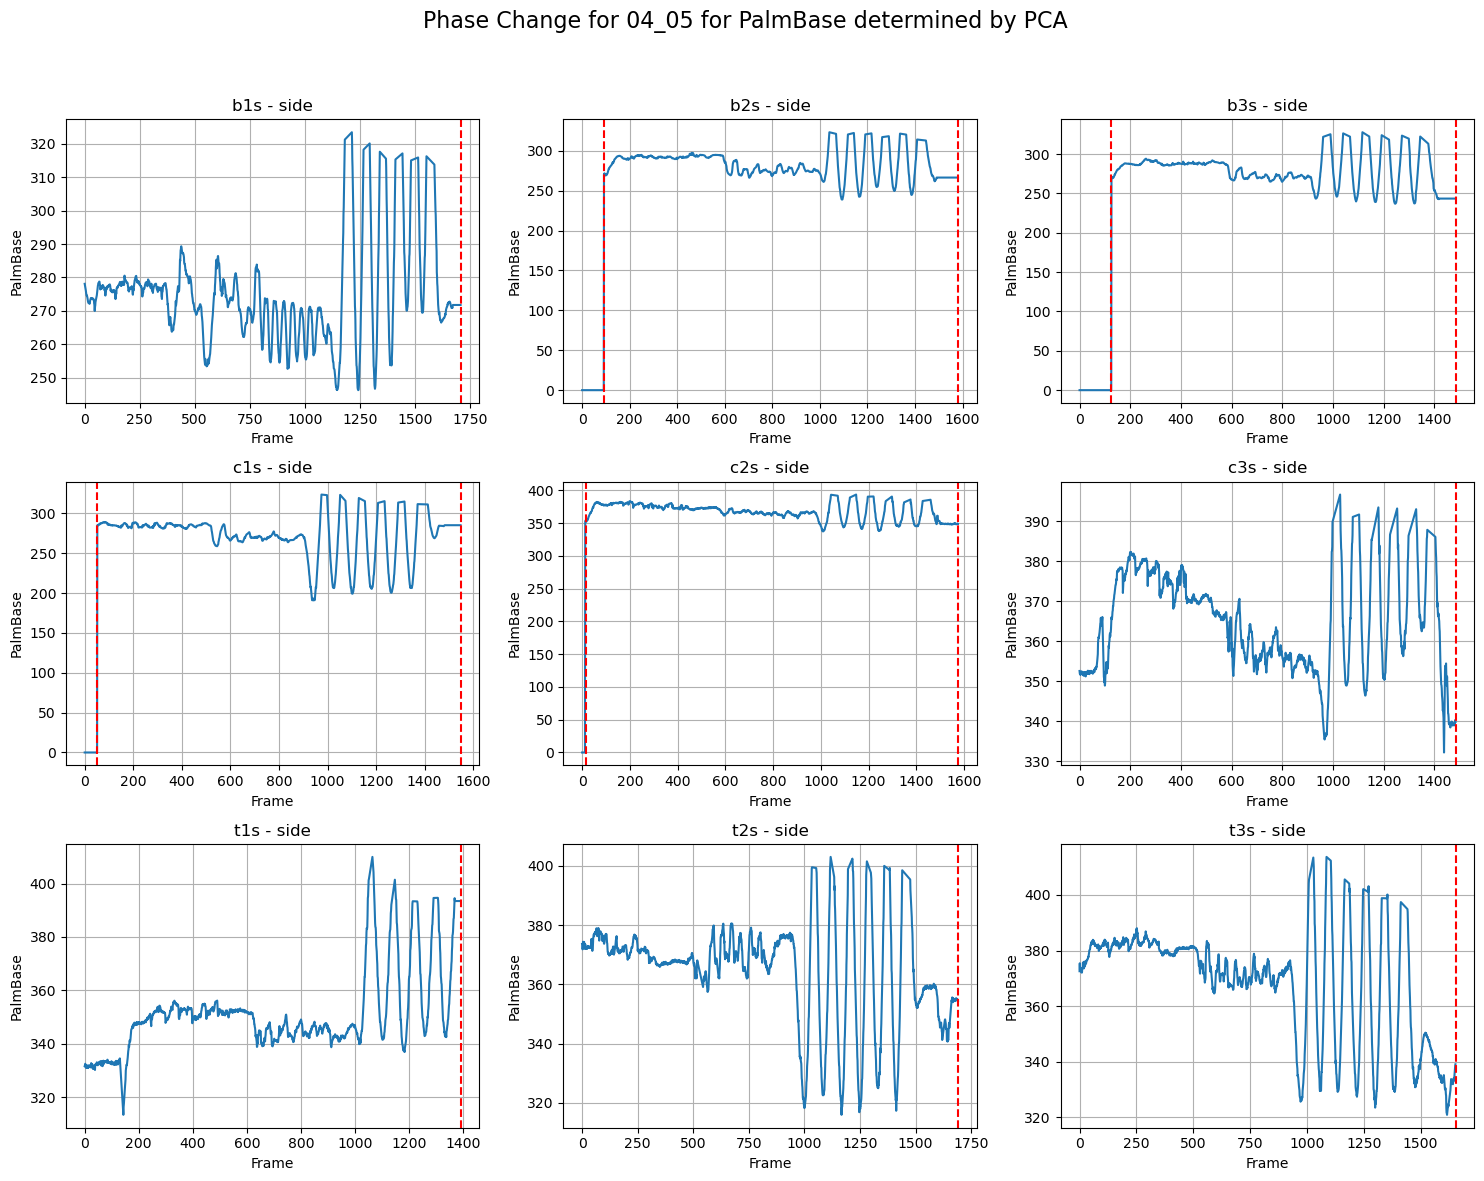

,dataset,movement,data,time,indices


In [103]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
IO_03_09_2023_RSTN = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_04_05_2023_RSTN_subject2\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(IO_03_09_2023_RSTN.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(IO_03_09_2023_RSTN.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")


import pandas as pd
import ruptures as rpt

# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['PalmBase']
    points_np = points.to_numpy()

    algo = rpt.Pelt(model='l2').fit(points_np)
    change_points = algo.predict(pen=1e6)

    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = change_points

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)

df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [4, 5]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['PalmBase'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='PalmBase')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("PalmBase")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title here
fig.suptitle("Phase Change for 04_05 for PalmBase determined by PCA", fontsize=16)

# Adjust layout to make room for suptitle
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['PalmBase'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()
